In [35]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from scipy import stats

# Data preprocessing
## Assign labels

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()

np.int64(307)

In [4]:
def classify(x):
    if x <= 100000:
        return 0
    if x <= 350000:
        return 1
    return 2

In [5]:
df["Label"] = df["SalePrice"].apply(classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [6]:
def missing(df, columns):
    return {column: df[column].isnull().sum() for column in columns if df[column].isnull().sum() > 0}

In [7]:
missing(df, df.columns)

{}

# Categorical data

In [ ]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [9]:
def unique(df, columns):
    return {column: df[column].nunique() for column in columns}

In [10]:
categorical_unique = unique(df, categorical_columns)

In [11]:
numeric_unique = unique(df, numeric_columns)

In [12]:
def plot_bar(values, title, size=(10, 4)):
    plt.figure(figsize=size)
    plt.bar(*zip(*values.items()))
    plt.title(title)
    plt.show()

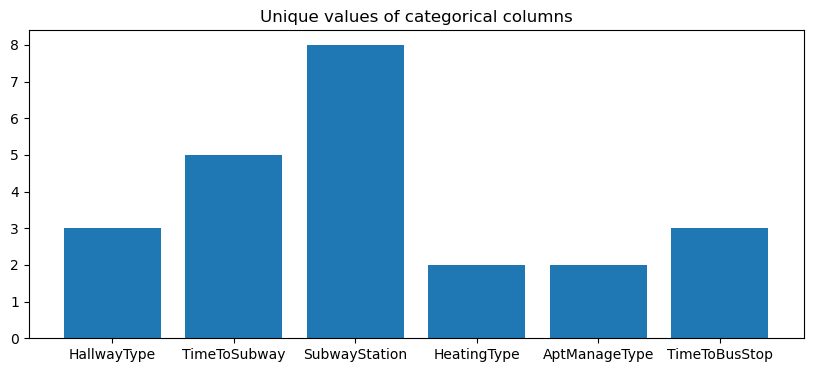

In [13]:
plot_bar(categorical_unique, "Unique values of categorical columns")

In [14]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

In [15]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

In [16]:
def plot_boxplot(df, numeric_columns):
	size_x = len(numeric_columns)//2
	size_y = len(numeric_columns)//size_x
	fig, axes = plt.subplots(size_x, size_y, figsize=(15, 25))
	for col, ax in zip(numeric_columns[:-1], axes.flatten()):
		ax.boxplot(df[col], patch_artist=True)
		ax.set_title(col)

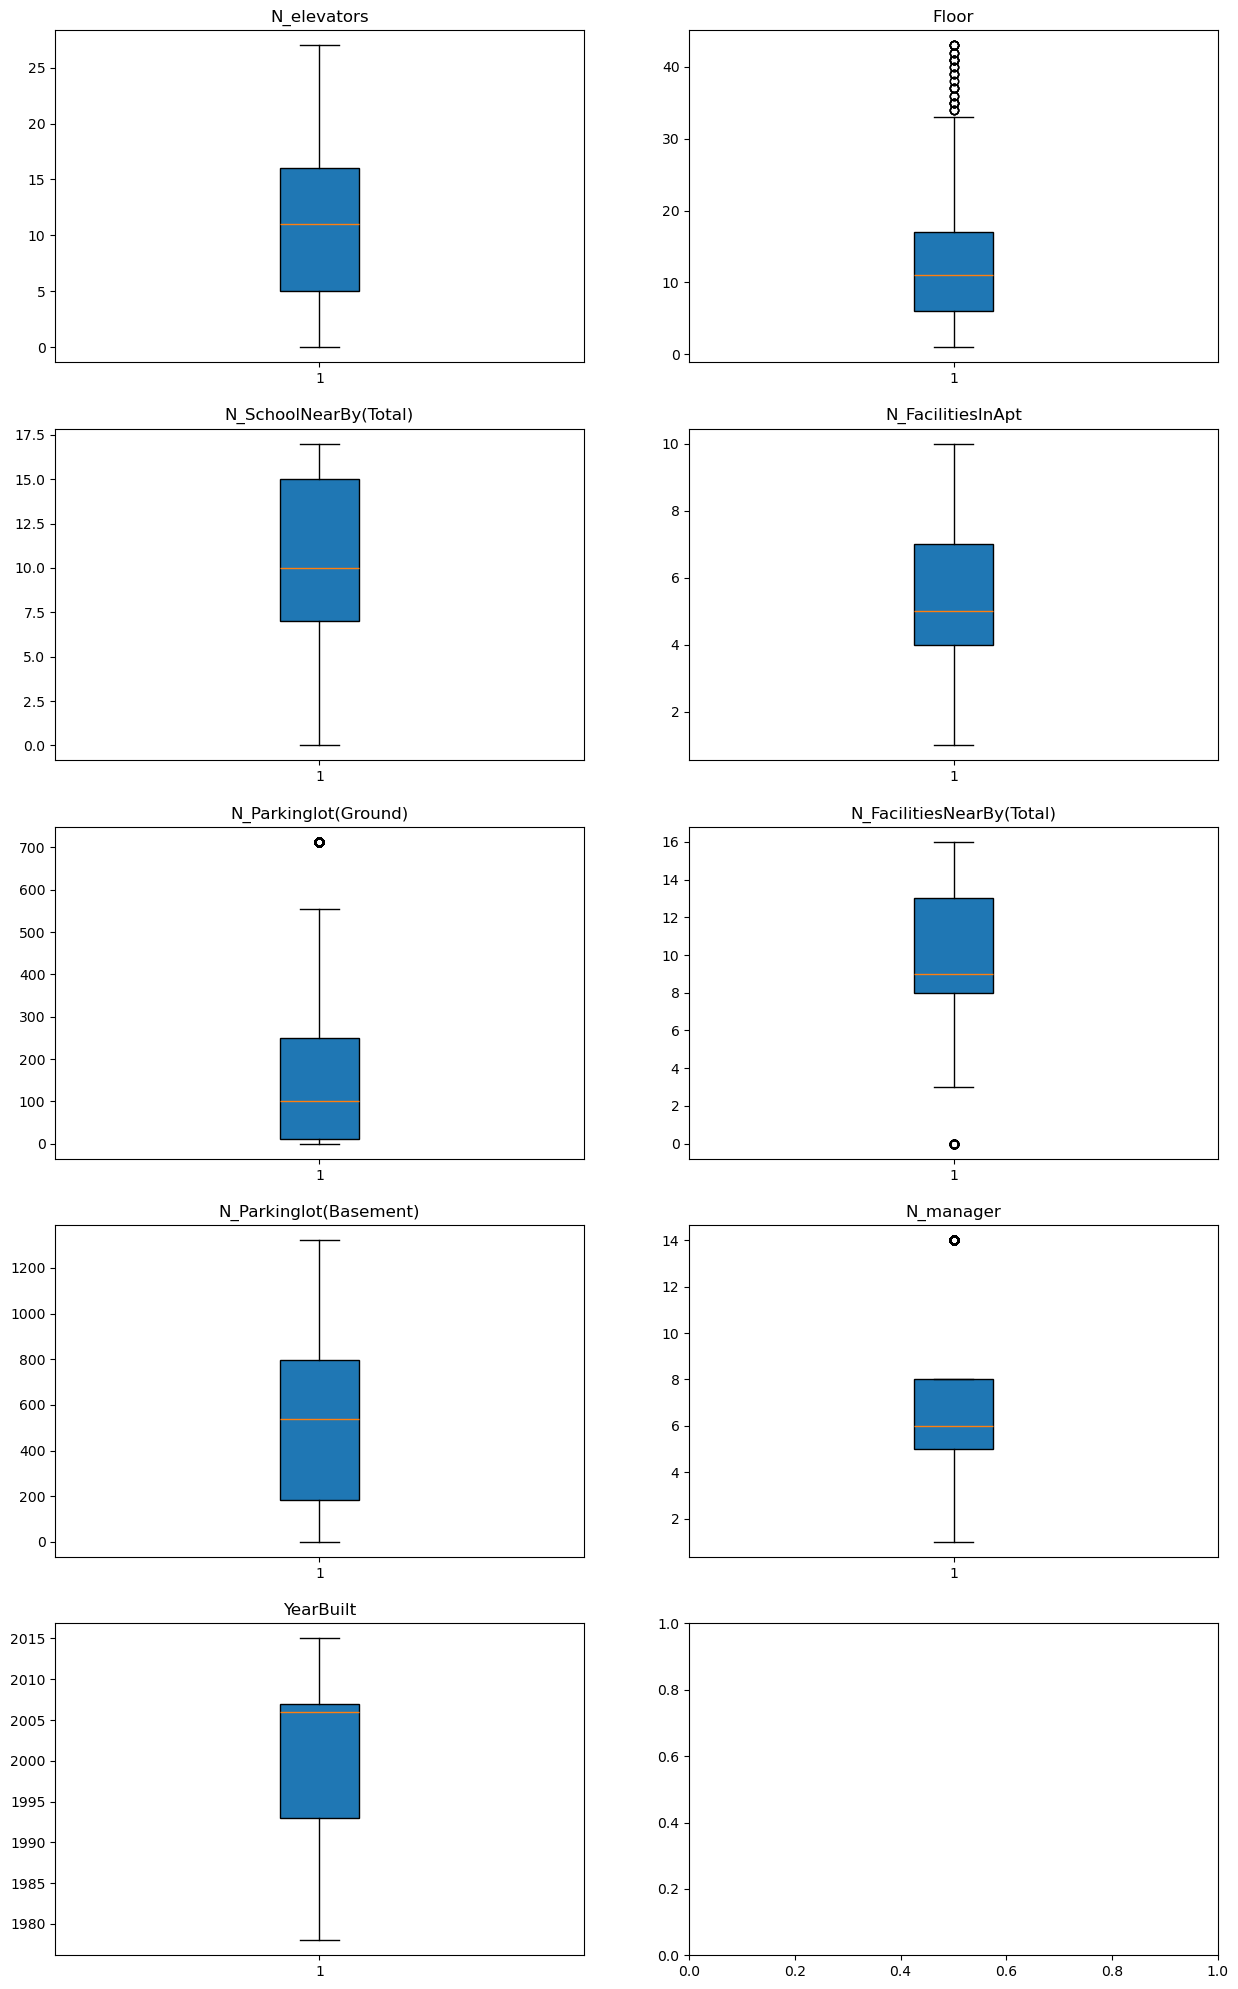

In [17]:
plot_boxplot(df, numeric_columns)

In [18]:
def check_outliers(df, numeric_columns):
    outliers = {}
    outliers_counts = {}
    for col in numeric_columns[:-1]:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_counts[col] = len(outliers[col])
    return outliers_counts, outliers

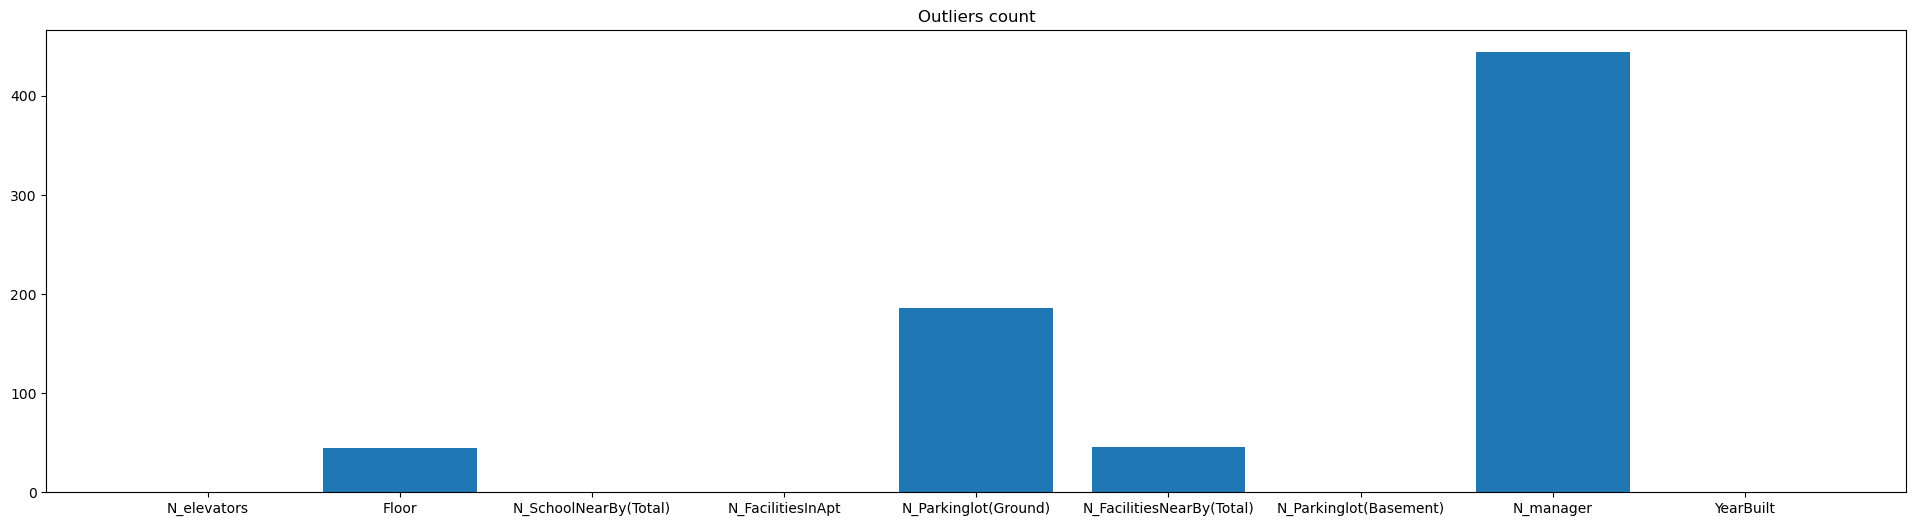

In [19]:
outliers_counts, outliers = check_outliers(df, numeric_columns)
plot_bar(outliers_counts, "Outliers count", size=(24, 6))

## Analyze if some features have normal distribution

In [20]:

def plot_histograms(df, numeric_columns):
    size_x = len(numeric_columns)//2
    size_y = len(numeric_columns)//size_x
    fig, axes = plt.subplots(size_x, size_y, figsize=(15, 25))
    for col, ax in zip(numeric_columns[:-1], axes.flatten()):
        df[col].plot(kind="hist", bins=20, ax=ax)
        ax.set_title(col)

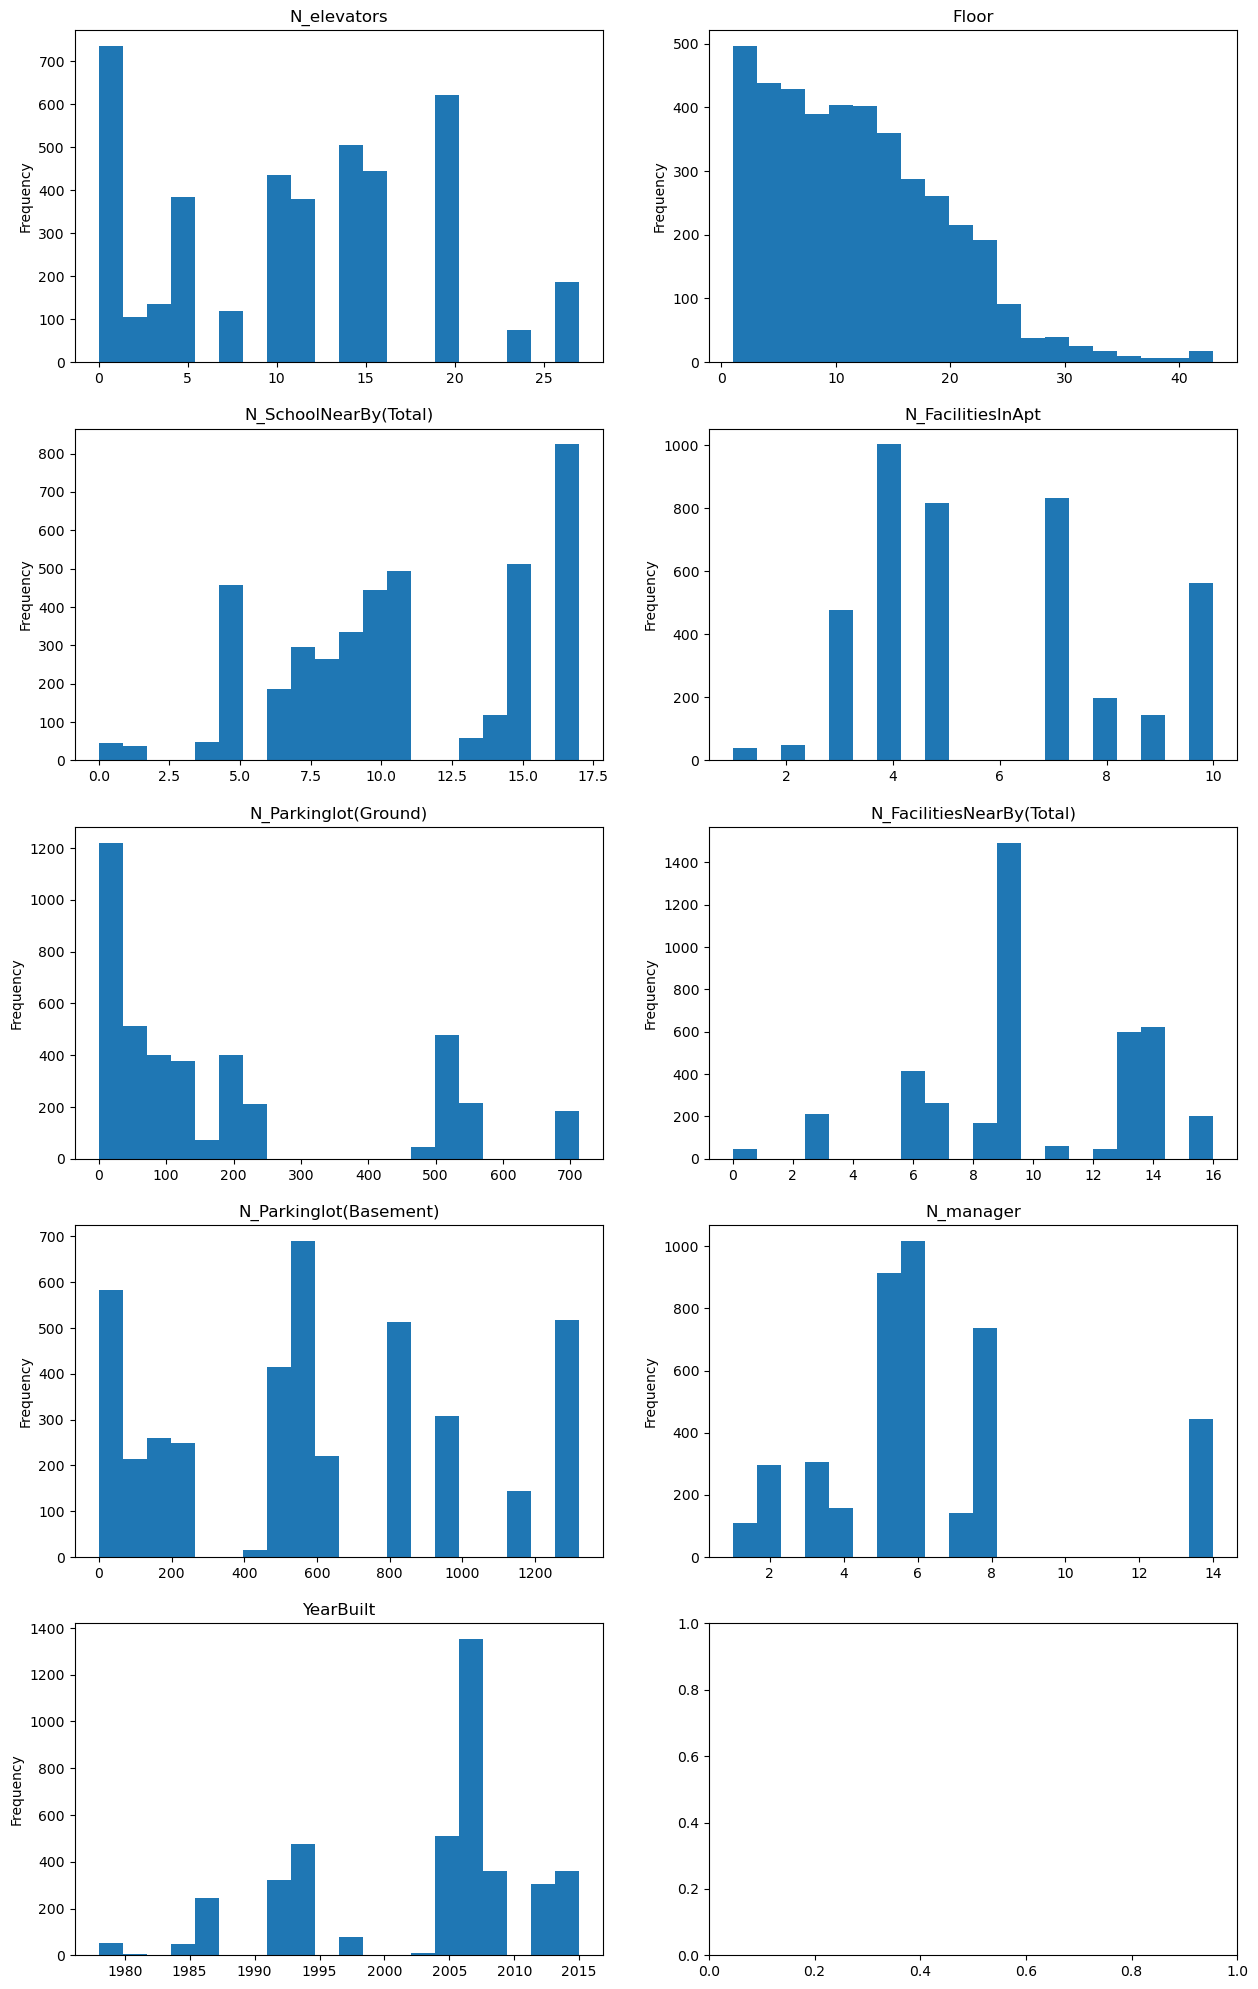

In [21]:
plot_histograms(df, numeric_columns)

In [22]:
def shapiro_wilk(df, numeric_columns):
	normally_distributed = {}
	positive = "normally distributed"
	negative = "not normally distributed"
	for col in numeric_columns[:-1]:
		shapiro_wilk_result = stats.shapiro(df[col])
		normally_distributed[col] = positive if shapiro_wilk_result.pvalue >= 0.05 else negative
	return normally_distributed

In [23]:
shapiro_wilk(df, numeric_columns)

{'N_elevators': 'not normally distributed',
 'Floor': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_Parkinglot(Basement)': 'not normally distributed',
 'N_manager': 'not normally distributed',
 'YearBuilt': 'not normally distributed'}

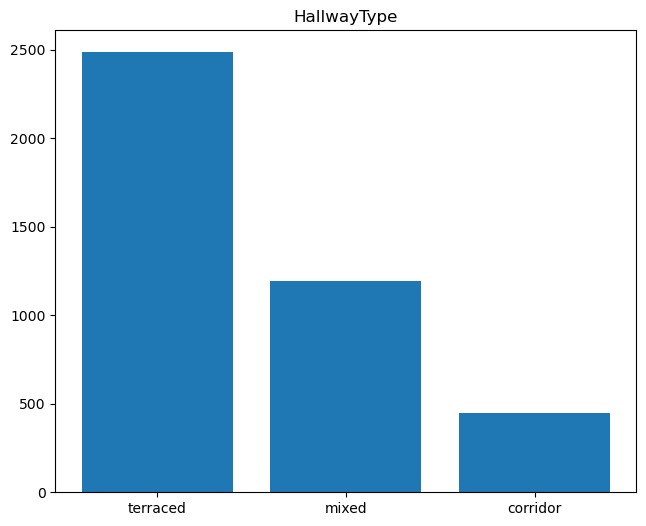

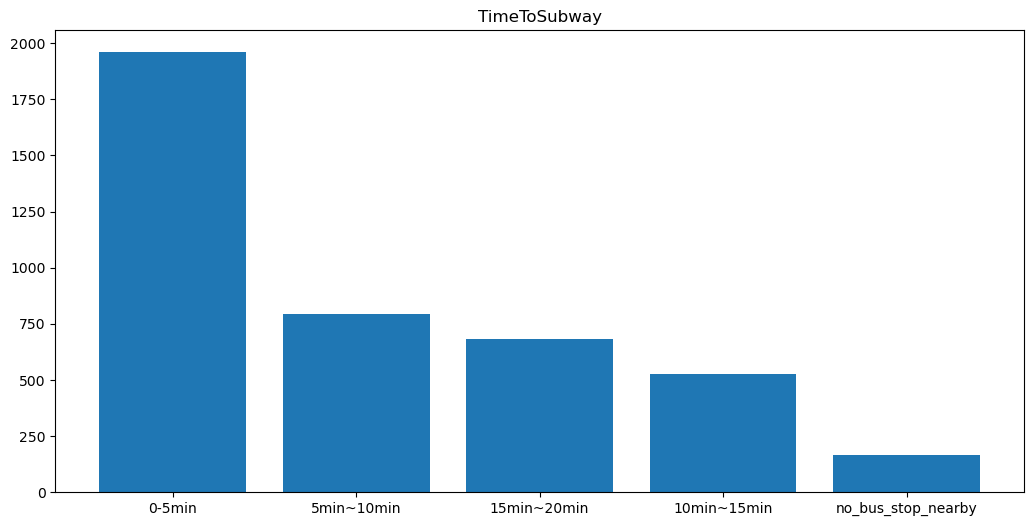

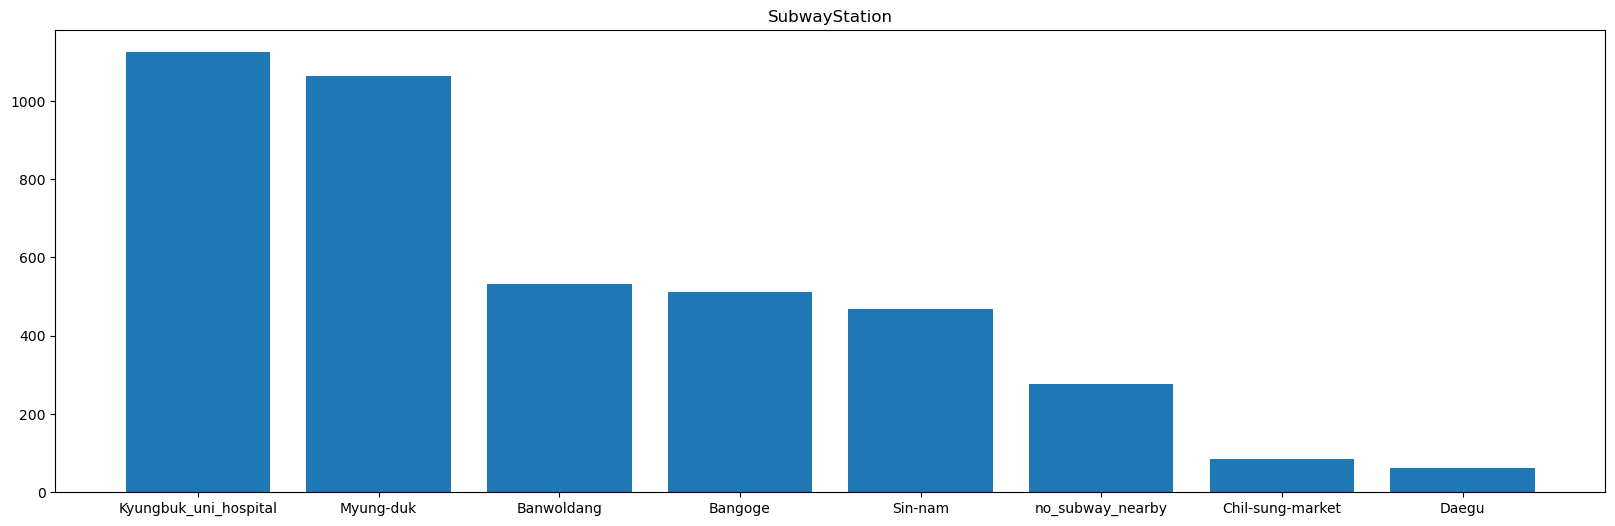

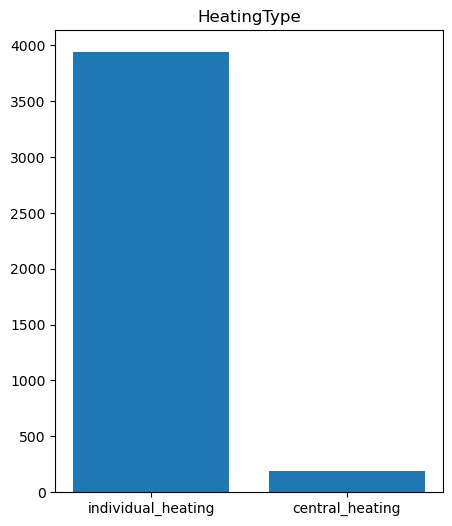

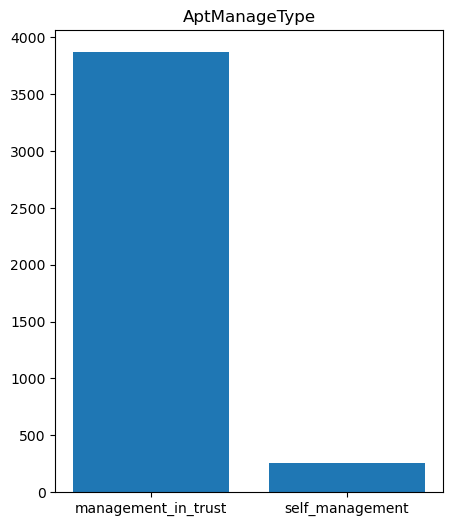

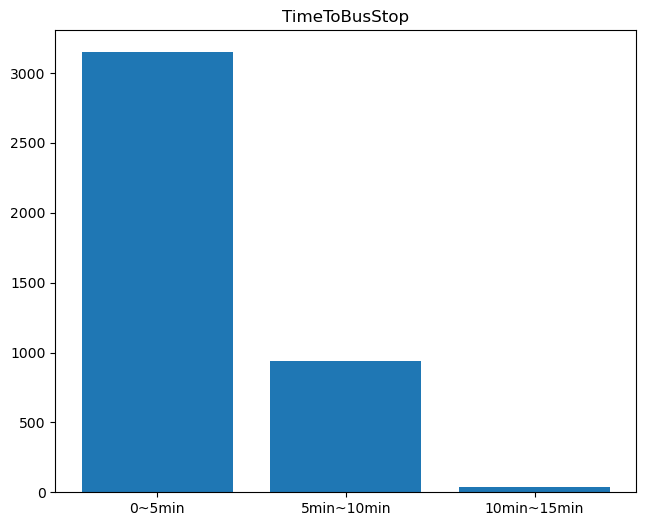

In [24]:
for col in categorical_columns:
    plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

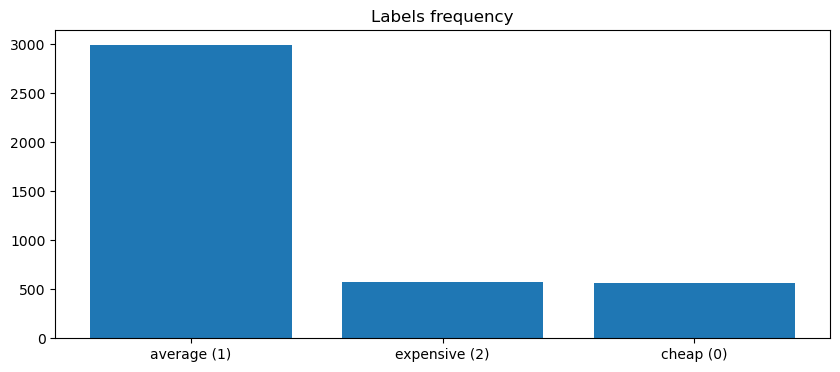

In [25]:
plot_bar(counts_by_label, "Labels frequency")

In [26]:
def preprocess(df, numeric_columns, ordinal_columns, nominal_columns):
    preprocessor = ColumnTransformer(transformers=[
        ("nominal", OneHotEncoder(handle_unknown="ignore"), nominal_columns),
        ("numeric_scaler", MinMaxScaler(), numeric_columns),
        ("ordinal", OrdinalEncoder(), ordinal_columns)
        ], remainder="passthrough")
    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessor),
    ])
    pipeline.fit(df)
    return pipeline.transform(df)
#TODO check if ordinal encoding does ordering right

In [38]:
y = df["Label"].to_numpy()
X = df.drop(columns=["Label"])
X = preprocess(X, numeric_columns, ordinal_columns, nominal_columns)
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)

In [39]:
train_dataset = TensorDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float())
val_dataset = TensorDataset(torch.from_numpy(val_x).float(), torch.from_numpy(val_y).float())

# Model and training

In [40]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(27, 64)
        self.bc1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bc2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.bc1(self.fc1(x)))
        x = F.relu(self.bc2(self.fc2(x)))
        x = self.fc3(x)
        return x


In [44]:
def train(model, training_dataset, epochs, lr, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        avg_loss = 0
        for input, label in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(input)
            print(y_pred, label)
            loss = criterion(y_pred, label)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
        print(f"Epoch: {epoch}, loss: {avg_loss//len(train_dataloader)}")

In [45]:
model = Model()
train(model, train_dataset, 30, 3e-4, 64)

tensor([[-0.2620,  0.1942,  0.1894],
        [-0.9334, -0.0498,  0.0621],
        [-0.6093, -0.0064,  0.3820],
        [-0.6125, -0.2128, -0.6437],
        [-1.0614,  0.3583,  0.2205],
        [-0.6979,  0.3418, -0.4096],
        [-0.6017,  0.0998, -0.4460],
        [-0.1786, -0.2491, -0.3624],
        [-1.1587,  0.3985,  0.3259],
        [-1.0794,  0.3389,  0.0288],
        [-1.0065,  0.0426, -0.3168],
        [-0.0809, -0.0273,  0.4474],
        [-1.0113,  0.0527, -0.3201],
        [-0.1495, -0.0449,  0.1959],
        [-0.2832,  0.1468, -0.0655],
        [-0.1132,  0.0371,  0.4091],
        [-0.7166,  0.2475, -0.0361],
        [-0.2871, -0.2358, -0.3470],
        [-0.7374,  0.2726,  0.0182],
        [-0.6394,  0.2686, -0.4087],
        [-0.7211,  0.2582, -0.0378],
        [-1.0306,  0.0685, -0.3266],
        [-0.0441,  0.2323,  0.2566],
        [-0.2244, -0.1231,  0.1222],
        [-0.7436,  0.2775,  0.0255],
        [-0.4065, -0.2575, -0.2265],
        [-0.9665,  1.2375, -0.4437],
 

RuntimeError: expected scalar type Long but found Float